# Minimum working example for modeling photostimulation in Zebrafish

Data Loading

In [1]:
import numpy as np
import pandas as pd
import photostimulation as ps
import adaptive_latents as al
from adaptive_latents import NumpyTimedDataSource, Bubblewrap, default_rwd_parameters, BWRun
from adaptive_latents.transforms.utils import prosvd_data

In [2]:
# Specify the paths to the files
stim_file_path = '../../generated/datasets/fish/output_020424_ds1/stimmed.txt'
C_file_path = '../../generated/datasets/fish/output_020424_ds1/analysis_proc_C.txt'
photo_file_path = '../../generated/datasets/fish/output_020424_ds1/photostims.npy'

# Load the files
stim = np.loadtxt(stim_file_path) 
"""1st entry: frame number,
2nd entry: ignore,
3rd entry: angle of motion L,
4th entry: angle of motion R,
5th entry: timestamp,"""
C = np.loadtxt(C_file_path)#
"""Calcium imaging. 
1st entry is neuron ID,
2nd is time (frame)"""
photostim = np.load(photo_file_path)
"""1st entry: frame number,
2nd entry: counter of stims,
3rd entry: neuron ID,
4th entry: position X of neuron,
5th entry: position Y of neuron,"""

# extra note: Fs= 2.3 Hz

'1st entry: frame number,\n2nd entry: counter of stims,\n3rd entry: neuron ID,\n4th entry: position X of neuron,\n5th entry: position Y of neuron,'

Run BW

In [3]:
#Perform dimensionality reduction
smallC_photo = prosvd_data(input_arr=C.T,output_d=7, init_size=20, centering=True)

retreiving cache from: /home/patriciobarber/AdaptiveLatents/generated/datasets/cache/prosvd_data_804066318027636.pickle


In [4]:
t = np.arange(smallC_photo.shape[0])
in_ds = NumpyTimedDataSource(smallC_photo, t, time_offsets=(0,1))
bw = Bubblewrap(dim=in_ds.output_shape, **dict(default_rwd_parameters, M=100, num=1000, B_thresh=-10, num_grad_q=1))

In [5]:
#run BW
br = BWRun(bw=bw, in_ds=in_ds)
br.run(limit=5500, save=False)

100%|█████████▉| 5383/5384 [10:39<00:00,  8.41it/s]


Extract the log predictive probability values

In [6]:
predictions_list = ps.extract_predictions([br], offset=1)

Create a data frame for photostimulation and log PP rankings

In [7]:
final_df=ps.rank_neurons(stim, C, photostim, predictions_list)

/home/patriciobarber/AdaptiveLatents/adaptive_latents/stimulation/photostimulation.py:125: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '15' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  modified_ids.loc[group.index[start_idx:start_idx + 5], 'neuron_ID'] = str(int(neuron_id) + 1)


In [8]:
#let's sort by change in log PP ranking
df_sorted = final_df.sort_values(by=['ranking', 'frame_number'])

df_sorted.iloc[:15]

,frame_number,stim_counter,neuron_ID,position_X,position_Y,drop_value,ranking,average_PP
80,3848,81.0,15,310.375977,394.756104,4.800206,1.0,-16.629704
81,3882,82.0,15,310.375977,394.756104,4.800206,1.0,-16.629704
82,3916,83.0,15,310.375977,394.756104,4.800206,1.0,-16.629704
83,3950,84.0,15,310.375977,394.756104,4.800206,1.0,-16.629704
84,3984,85.0,15,310.375977,394.756104,4.800206,1.0,-16.629704
115,5047,116.0,103,329.839386,94.865532,3.239005,2.0,-15.496391
116,5076,117.0,103,329.839386,94.865532,3.239005,2.0,-15.496391
117,5110,118.0,103,329.839386,94.865532,3.239005,2.0,-15.496391
118,5147,119.0,103,329.839386,94.865532,3.239005,2.0,-15.496391
119,5185,120.0,103,329.839386,94.865532,3.239005,2.0,-15.496391


Plotting trajectories with PCA and proSVD for particular neuron trials

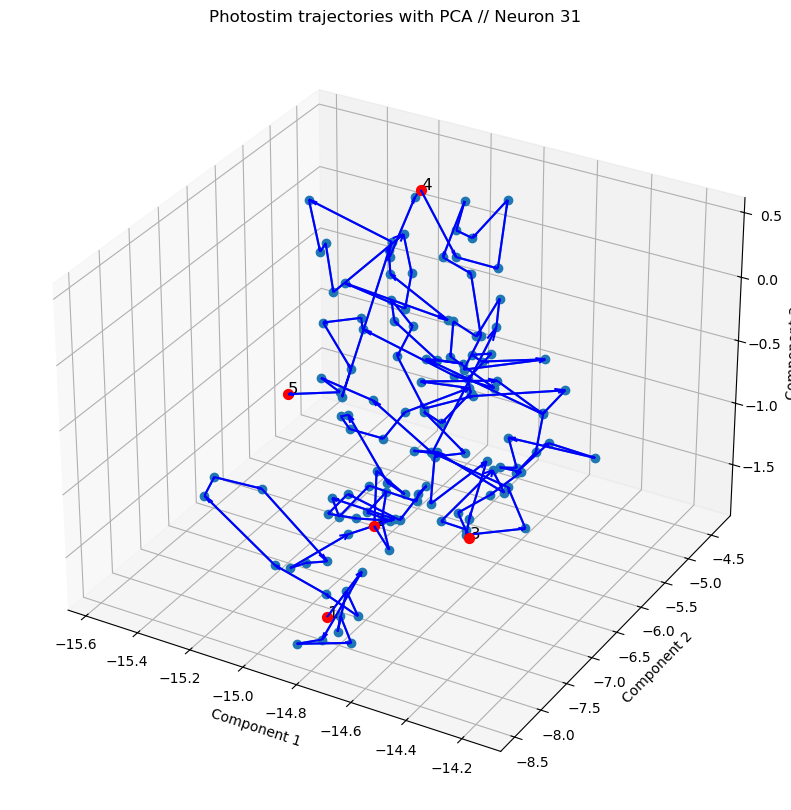

In [14]:
ps.plot_photostim(31,'pca',C, photostim, final_df)

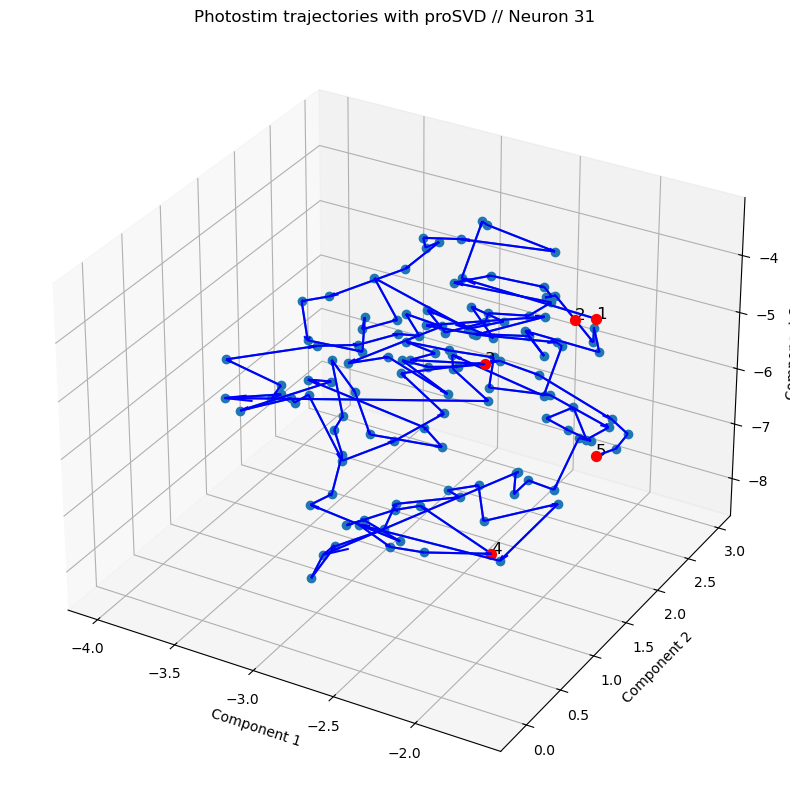

In [15]:
ps.plot_photostim(31,'proSVD',C, photostim, final_df)

Plot the Log PP of a determined neuron 

Note: I decided to limit the graph using frame numbers instead of neuron_ID for flexibility, so
you need to look in the data frame the desired start and end 

Adding red lines at frame numbers: [1114. 1148. 1182. 1216. 1249. 1284. 1318. 1352. 1386. 1418. 1454. 1488.
 1522. 1555. 1590. 1624. 1658. 1693. 1727. 1759. 1794. 1829. 1864. 1899.
 1935. 1969. 2002. 2036. 2069. 2106. 2142. 2176. 2212. 2246. 2280. 2310.
 2345. 2381. 2413. 2448. 2484. 2518. 2552. 2585. 2621. 2655. 2689. 2721.
 2757. 2791. 2824. 2854. 2893. 2927. 2961. 2995. 3027. 3062. 3095. 3129.
 3167. 3201. 3233. 3269. 3302. 3338. 3372. 3406. 3440. 3472. 3508. 3541.
 3576. 3610. 3644. 3674. 3706. 3739. 3775. 3812. 3848. 3882. 3916. 3950.
 3984. 4018. 4052. 4085. 4111. 4150. 4185. 4221. 4258. 4291. 4323. 4355.
 4394. 4429. 4465. 4499. 4533. 4567. 4601. 4635. 4669. 4703. 4733. 4771.
 4804. 4839. 4873. 4910. 4944. 4976. 5008. 5047. 5076. 5110. 5147. 5185.
 5217. 5245. 5280. 5324. 5355. 5391.]


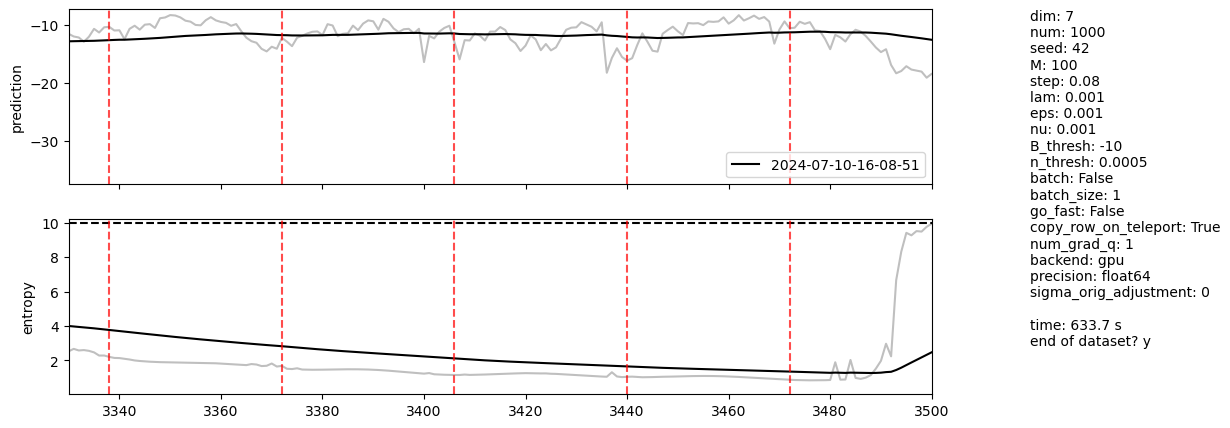

In [16]:
#for neuron 31:
al.plotting_functions.compare_metrics([br], offset=1, red_lines_frames=photostim[:, 0] , xlim_start=3330, xlim_end=3500)

In case you want to see how BW is fittinfg the data:

WARNING: it takes a long time to render

In [17]:
"""
#proSVD in two dimensions and run BW

smallC_photo = prosvd_data(C.T,2, 20, centering=True)
t = np.arange(smallC_photo.shape[0])
in_ds = NumpyTimedDataSource(smallC_photo, t, time_offsets=(0,1))
bw = Bubblewrap(dim=in_ds.output_shape, **dict(default_rwd_parameters, M=100, num=1000, B_thresh=-10, num_grad_q=1))
#run BW
br = BWRun(bw=bw, in_ds=in_ds)
br.run(limit=5500, save=False)

#create animation
ps.bw_animation(smallC_photo, bw.A, bw.mu, bw.L, bw.n_obs, save_path='fishBW_animation3.mp4', fps=10)"""

"\n#proSVD in two dimensions and run BW\n\nsmallC_photo = prosvd_data(C.T,2, 20, centering=True)\nt = np.arange(smallC_photo.shape[0])\nin_ds = NumpyTimedDataSource(smallC_photo, t, time_offsets=(0,1))\nbw = Bubblewrap(dim=in_ds.output_shape, **dict(default_rwd_parameters, M=100, num=1000, B_thresh=-10, num_grad_q=1))\n#run BW\nbr = BWRun(bw=bw, in_ds=in_ds)\nbr.run(limit=5500, save=False)\n\n#create animation\nps.bw_animation(smallC_photo, bw.A, bw.mu, bw.L, bw.n_obs, save_path='fishBW_animation3.mp4', fps=10)"